# Artifacts of memory 

In this notebook I would like to present you the pipeline leading to matching and overlapping lines from video archives to lines on the query image.

### The pipeline
The pipeline consists of two main parts. The first part concerns dealing with the video archives and the second part with matching the lines from a query image with the matched lines from the archive.

#### **Step 1**: Preprocess the video archives into a format from which we can extract lines. This has to only be done once.
- Sample frames from videos to work on static data
- For each frame, run a line extraction together with additional line features such as line angle and length.
- Discard the frames with no detected lines and filter out weak (short) and closely similiar lines (reduce noise and dimensionality for later retrival)
- Save the information about the filtered data in an format that is easy to query (we chose Pandas dataframe)
    
#### **Step 2**: Extract and match the lines from the query image to the database of candidate matches from the archive.
- run the line extraction and filter algorithm on the query image
- choose the line(s) to be matched. How? We prefer long, non-horizontal lines.
- perform the matching procedure
- fetch the match and overlay it on the query image

That's it!

Let's proceed from talking to doing:

In [1]:
# Import the libaries

import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

np.random.seed(1998)

# Step 1
## How to find lines in an image? 
To find the lines in the images, we are using a method called **Hough transform**. It works on the basis of represnting a line with $(\rho, \theta)$ pair, where $\rho$ stands for a distance from the origin and $\theta$ for the angle between the line and x axis. Note that the line represented using these parameters can be represented as a point in the **Hough Space**. The points that lay on the line characterised by $(\rho, \theta)$ must by definition intersect in the Hough Space. We make use of that fact and scan the the Hough Space for intersections.

More on hough lines can be found in [this article](https://medium.com/@tomasz.kacmajor/hough-lines-transform-explained-645feda072ab). An extension of Hough transform that we are actually using is called **Probabilisitc Hough Transform** that uses geometric properties of curves in the Hough Space to make the whole process more efficient. More on that [here](https://en.wikipedia.org/wiki/Randomized_Hough_transform).

This method has a few parameters that determine how many lines are detected. I've described the direct impact of those parameters but their interpretation can be found in the first article.

In [2]:
# Set the parameters for hough line

rho_resolution = 1 # the discretization parameter for rho: not recommended to change
theta_resolution = np.pi/180 # the discretization parameter for theta: not recommended to change

threshold = 100 # The minimum number of intersections in hough space to "detect" a line. higher -> less lines

# Additional parameters for probabilistic ho
minLineLength = 150 # The minimum number of points that can form a line. Lines with less than this number of points are disregarded. higher -> less lines
maxLineGap = 30 # The maximum gap between two points to be considered in the same line. higher -> more lines

## Detecting lines step by step
Additionally, to prevent weak lines from going through, we slightly blur the image. Next, as hough lines expects binary input, we first run the image through a **Canny Edge detector**. Below see the stages of detecing a line:

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7fe52b92e490>)

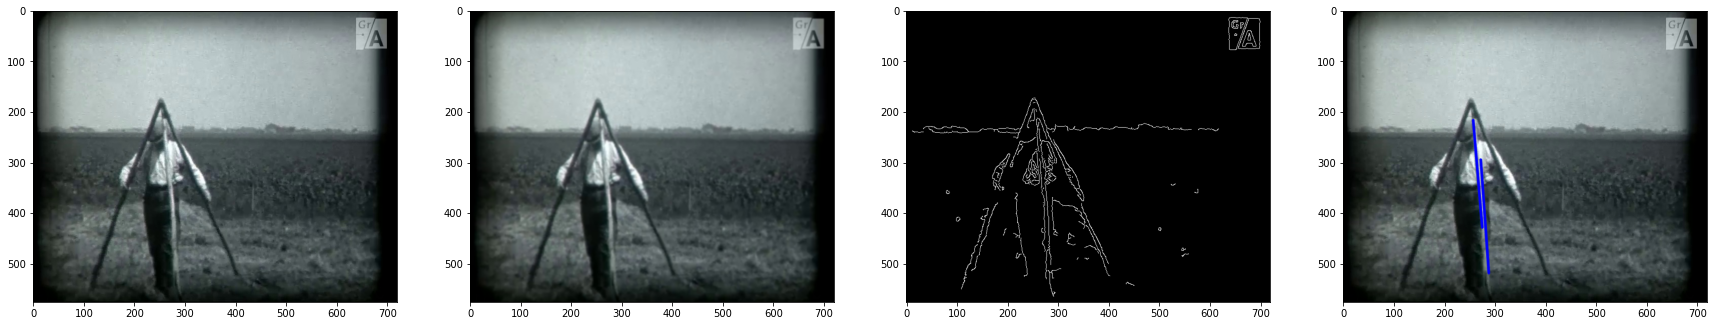

In [3]:
img = plt.imread("archives/AV0843/keyframe_9145.0.jpg")
blurred_image = cv2.GaussianBlur(img, (5, 5), 0) # filter out week lines
edges_image = cv2.Canny(blurred_image, 50, 120,None, apertureSize = 3)  # without Blur
hough_lines_p = cv2.HoughLinesP(edges_image, rho_resolution, theta_resolution, threshold, None, minLineLength, maxLineGap)

original_image_with_hough_lines = img.copy()

# Plotting
for i in range(0, len(hough_lines_p)):
        l = hough_lines_p[i][0]
        cv2.line(original_image_with_hough_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
    
plt.figure(figsize = (30,20))
plt.subplot(141), plt.imshow(img)
plt.subplot(142), plt.imshow(blurred_image)
plt.subplot(143), plt.imshow(edges_image, cmap='gray')
plt.subplot(144), plt.imshow(original_image_with_hough_lines, cmap='gray') 

Note that we did not get all the lines. And that's okay. By tunning the parameters we could return more lines but at a cost: we would return **false** lines. But we care more about **precision** (how many returned items are relevant) rather than **recall** (ratio of returned relevant items to the total relevant items). High false positive rate would ruin our matches later.

### Repeat for all frames in the archive...

We perform procedure above for all the frames we sampled from the archive together with extra length and angle information per line.
There is quite a bit of code to make that work efficiently.

## class matchingObject 
Since we need to keep track of a lot of information about the image, we create a class that will help us be more efficient: 

In [4]:
def apply_hough(img, threshold = threshold, minLineLength = minLineLength, maxLineGap = maxLineGap, probabilistic = True):
    """Applies the Hough transform""" 
    
    if probabilistic:
        blurred_image = cv2.GaussianBlur(img, (5, 5), 0) # filter out week lines
        edges_image = cv2.Canny(blurred_image, 50, 120,None, apertureSize = 3)  #  applying Canny on the blurred image
        hough_lines = cv2.HoughLinesP(edges_image,rho_resolution, theta_resolution, threshold, None, minLineLength, maxLineGap)
        
    else:
        blurred_image = cv2.GaussianBlur(img, (7, 7), 0) # filter out week lines
        edges_image = cv2.Canny(blurred_image, 50, 150, apertureSize = 3) # 120 is another visually optimal value 
        hough_lines = cv2.HoughLines(edges_image, rho_resolution , theta_resolution , threshold)
     
    return hough_lines

def get_angle(hough_lines, radians = False):
    if radians:
        return np.arctan2(hough_lines[:, :,3] - hough_lines[:, :,1], hough_lines[:, :,2] - hough_lines[:, :,0])
    else: 
        return np.arctan2(hough_lines[:, :,3] - hough_lines[:, :,1], hough_lines[:, :,2] - hough_lines[:, :,0]) * 180/np.pi # better for numerical stability
    

def plot_lines(img, hough_lines, probabilistic = True):
    """Plots only probabilistic """

    original_image_with_hough_lines = img.copy()
    cmap = "gray" if img.shape[-1] == 3 else None 
        
    if probabilistic:
        for i in range(0, len(hough_lines)):
            l = hough_lines[i][0]
            cv2.line(original_image_with_hough_lines, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)
            #break
    
    else:
        hough_lines_image = np.zeros_like(img)
        draw_lines(hough_lines_image, hough_lines)
        original_image_with_hough_lines = weighted_img(hough_lines_image,img)
    
    plt.figure(figsize = (15,10))
    plt.subplot(121), plt.imshow(img)
    plt.subplot(122), plt.imshow(original_image_with_hough_lines, cmap=cmap) 
    
"""
# Example usage
probabilistic = True

img = plt.imread("frames/AV0843/keyframe_9145.0.jpg")
hough_lines = apply_hough(img, probabilistic = probabilistic)
plot_lines(img, hough_lines, probabilistic = probabilistic)
""";

In [5]:
class matchingObjects:
    """
    Stores frequently accessed information about the images and contains methods useful for line fitting.
    
    Attributes:
    --------------------
    path: str
        if file is read from directory, path stores that directory
    img: np.array
        stores the image in the RGB fashion
    margin: int
        defines how much the borders should be clipped. Useful for old images that have black borders resulting in fake line detections
    shape: np.array
        stores shape of the image
    scale: float
        the scaling factor compared to the original image
    lines: np.array
        strores the x_start,y_start, x_end, y_end corrdinates of the line in the image with a given scale and margin (not the orignal image)
    angle: np.array
        stores the angle of the detcted lines corresponding to the lines at the same index as in the "lines" atrribute
    slope: np.array
        stores the slope of the detcted lines corresponding to the lines at the same index as in the "lines" atrribute
    length:
        stores the length of the detcted lines corresponding to the lines at the same index as in the "lines" atrribute
        
    
    Methods:
    -------------------
    
    hough_lines(self, probabilistic = True, radians = False, **kwargs):
        Applies probabilistic or non-probabilisitc hough transform and calculates the characteristics of found lines
    
    rank_and_pick_lines(self, delta_angle = 1, max_lines = None):
        Filters out lines having similiar angles (taking the longest line out of the "similiar ones") to later limit the dimensionality of the database of lines.
    
    """
    
    def __init__(self, path = None, margin = 50, img = None, scale = 1):
        """
        Parameters:
        -----------------
        path: str
            if file is read from directory, path stores that directory. If supplied, img is expected to be none.
        margin: int
            defines how much the borders should be clipped. Useful for old images that have black borders resulting in fake line detections. 
            Remeber to adjust your margin with scale!
        scale: float
            the scaling factor compared to the original image
        img: np.array
            stores the image in the RGB fashion. If supplied, path is expected to be none.
        """
        self.scale = scale
        if img is None: # read in the image from path
            
            self.path = path 

            if margin > 0: # deals with black borders that result in many fake line detections
                self.img = plt.imread(self.path)[margin:-margin, margin:-margin]
            else:
                self.img = plt.imread(self.path)
        

        elif path is None: # np array image is provided
            self.path = None
            if margin > 0: # deals with black borders that result in many fake line detections
                self.img = img[margin:-margin, margin:-margin]
            else:
                self.img = img   
        
        self.shape = self.img.shape
        
        if scale != 1:
            self.img = cv2.resize(self.img, (int(self.shape[0] * self.scale), int(self.shape[1] * self.scale)))
            self.shape = self.img.shape
       
    
    def hough_lines(self, probabilistic = True, radians = False, **kwargs):
        
        """
        Applies  probabilistic or non-probabilistic hough transform to find lines. Additionally, for each line, it determines the angle, slope and length.
        
        Parameters:
        -----------------
        probabilistic: bool
            Determings whether probabilistic or non-probabilistic hough transform is applied
        radians: bool
            Determines whether to use radians. False is preffered due to possible numerical underflow problems later.
        **kwargs: optional
            Additional arguments specyfing the parameters of the hough transform. Useful as the default has been optimized for archival, medium resolution photos
        
        """
        self.lines = apply_hough(self.img, probabilistic= probabilistic, **kwargs)

        if self.lines is not None: # if hough found something
            self.angle = get_angle(self.lines, radians = radians) # radians more stable
            
            x_diff = self.lines[:, :,2] - self.lines[:, :,0]# if 0 then slope will be -inf -> vertical line
            y_diff = self.lines[:, :,3] - self.lines[:, :,1] 
            #self.slope = y_diff/x_diff
            self.length = np.sqrt(x_diff**2 + y_diff**2)
    
    def rank_and_pick_lines(self, delta_angle = 1, max_lines = None):
        """
        Filters out lines having similiar angles (taking the longest line out of the "similiar ones") to later limit the dimensionality of the database of lines.
        
        Parameters:
        -----------------
        delta_angle: float
            defines how close the angles have to be considered 'similiar' in terms of the angle
        max_lines:int
            specifiecs how many lines should be kept after filtering. The longest max_lines number of lines are kept.
        """

        initial_max = np.max(self.length)
        if self.lines is not None:
            lst0 = self.lines
            order = np.arange(0, len(lst0)).reshape(-1,1)
            lst1 = self.angle
            lst2 = self.length
            merged = np.concatenate([lst1, lst2, order], axis = 1)
            new_order = np.lexsort((lst2, lst1), axis = 0) # sorts first by angle then by length
            merged_new = merged[new_order]  #
            
            
            mask = ( np.diff(merged[new_order], axis = 0)[:,:,0] < delta_angle ) # boolean mask indicating whether the sorted values are withing delta_angle of each other
            series = False 
            
            for i in range(len(mask)): # marks 
                if mask[i] == True:
                    series = True
                elif (mask[i] == False) and (series == True):
                    mask[i] = True # make up for the offset in the mask
                    series = False # break the series
                    
            
            grouping_mask = np.concatenate((mask, np.array([[False]])) ) # adding the dimension lost by np.diff
            accum = [] #stores the longest line from found clusters 
            temp = [] # empty list for booking within clusters of similiar lines


            for i in range(len(grouping_mask)):  
                if grouping_mask[i] == False:
                    if (len(temp)>0): 
                        accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                        temp = []
                    accum.append(merged_new[i,:,:])


                else: #if grouping_mask[i] == True:
                    if len(temp) > 0:
                        if abs(merged_new[i,:,:][0][0] - temp[-1][0][0]) < delta_angle: 
                            temp.append(merged_new[i,:,:])
                        else: 
                            
                            accum.append(np.array(temp)[np.argmax(np.array(temp), axis = 0)[0][1]])
                            temp = []
                            temp.append(merged_new[i,:,:])
                    else:

                        temp.append(merged_new[i,:,:])
            
            accum = np.array(accum)
            accum = accum[np.argsort(accum[:,:,1], axis = 0)] # sort by length
            if max_lines is not None: # if the maximum number of lines to be returned is specifed, pick the longest max_lines lines
                accum = accum[-max_lines:]
            cleaned_order = list(accum[:,:,:,2].flatten().astype(int))
            
            #Update the attribute values
            self.lines = self.lines[cleaned_order]
            self.angle = self.angle[cleaned_order]
            self.length = self.length[cleaned_order]
            #self.slope = self.slope[cleaned_order]
            final_max = np.max(self.length)
        
            assert (abs(final_max - initial_max) < 0.01) # making sure the line of max length is preserved
            
        
        def plot_matches(self, matches, buffer = 5):
            self.matched_img = np.copy(self.img)
            pass
                
def get_non_zero_objects(obj_list):
    """
    Filters out images where no lines were found.
    
    Parametrs:
    ------------------
    obj_list: list
        List of elements of class matchingObjects
    
    """
    new_obj_list = []
    count_lines = 0
    for obj in obj_list:
        if obj.lines is not None:
            new_obj_list.append(obj)
            count_lines += len(obj.lines)
            
            
    print("{}% of input list contain lines".format(round(len(new_obj_list)/len(obj_list) * 100), 2))
    print("Given that the img contains a line, on average there are {} detected lines per image".format( round( count_lines/len(new_obj_list), 2 ) ))
    return new_obj_list

In [6]:
# Get the omage paths
img_directory = os.listdir("archives")
img_paths = []
temp_list = []
for directory in img_directory:
    temp_list += list(os.listdir(os.path.join("archives",directory)))
    
    for path in temp_list:
        img_paths.append(os.path.join("archives", directory, path))
        
    temp_list = []
    

img_paths = list(sorted(img_paths))

np.random.seed(1998)

start = time.time()
#img_paths = np.random.choice(img_paths, size = int(0.01*len(img_paths)), replace = False).astype(str) # take a random sample of 10$ of one directory
img_objects = np.array([matchingObjects(path, scale = 0.9) for path in img_paths])

# Apply hough transform to all objects in the array above
for obj in img_objects:
    obj.hough_lines()
    
non_zero_objects = get_non_zero_objects(img_objects)

print("Running hough lines for {} images took {} seconds.".format(len(img_paths), round(time.time() - start, 2)))

65% of input list contain lines
Given that the img contains a line, on average there are 7.87 detected lines per image
Running hough lines for 3330 images took 55.15 seconds.


### Rank and pick lines method
Sometimes our algorithm returns many overlapping lines in the same place artifically increasing the size of the database of our matches. We need to filter out these lines based on:
- how similiar the lines are in terms of angle
- take the longest line out of those considered "similiar"

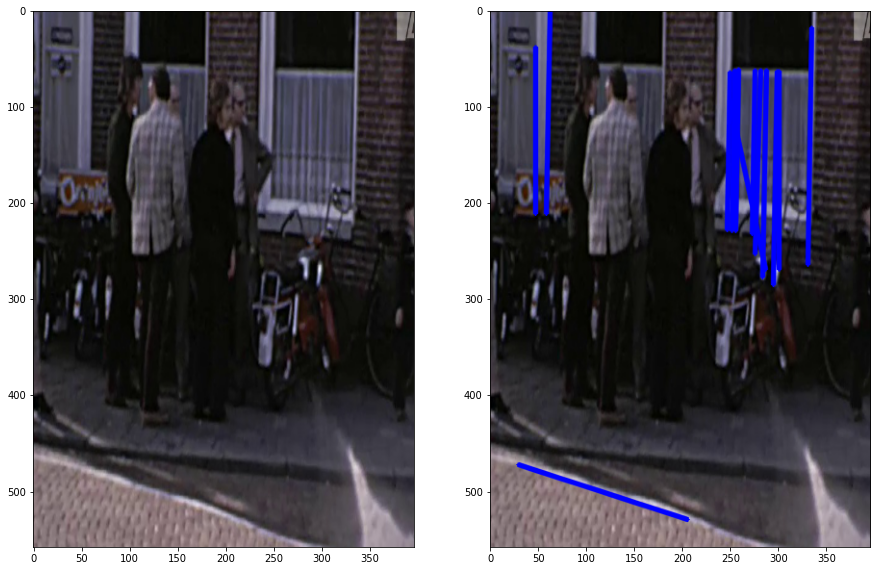

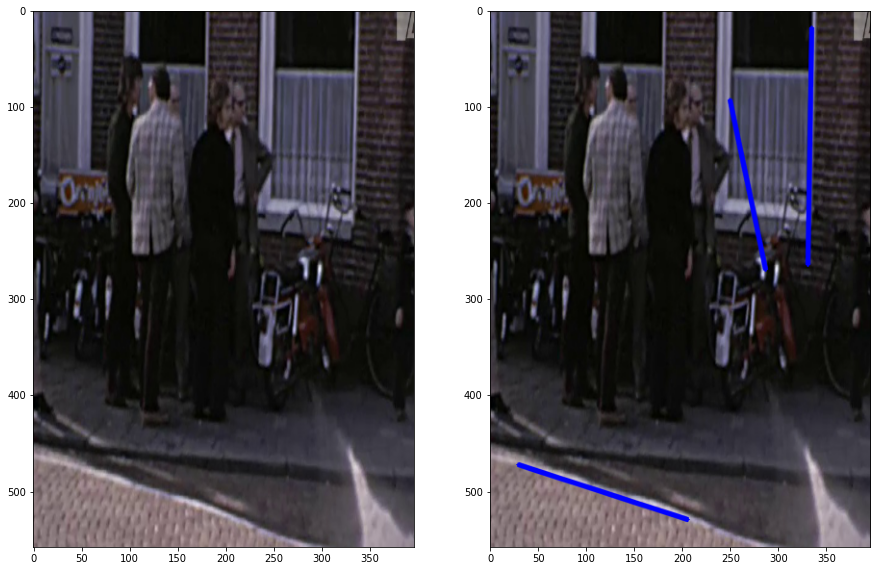

In [7]:
sample_number = 1000# 80
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)
non_zero_objects[sample_number].rank_and_pick_lines(delta_angle=3, max_lines=None) # works in place!!
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)

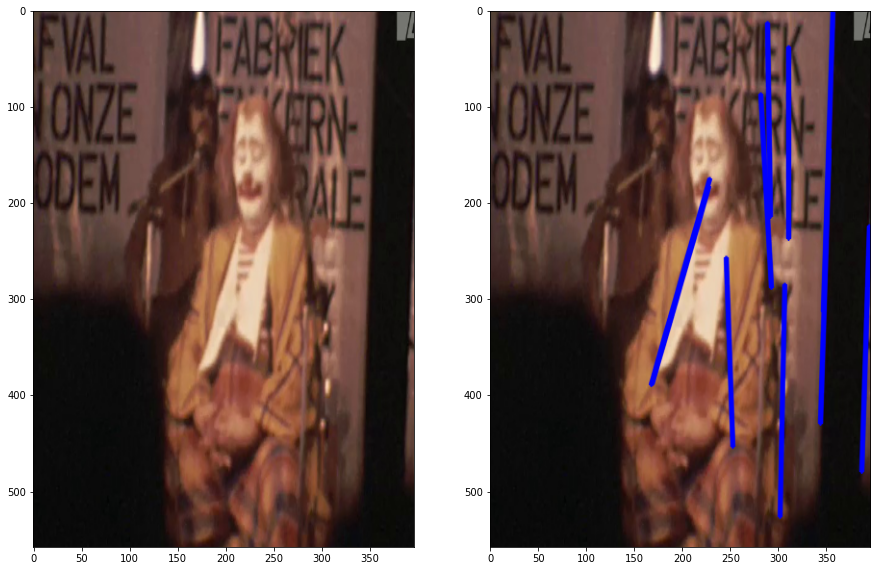

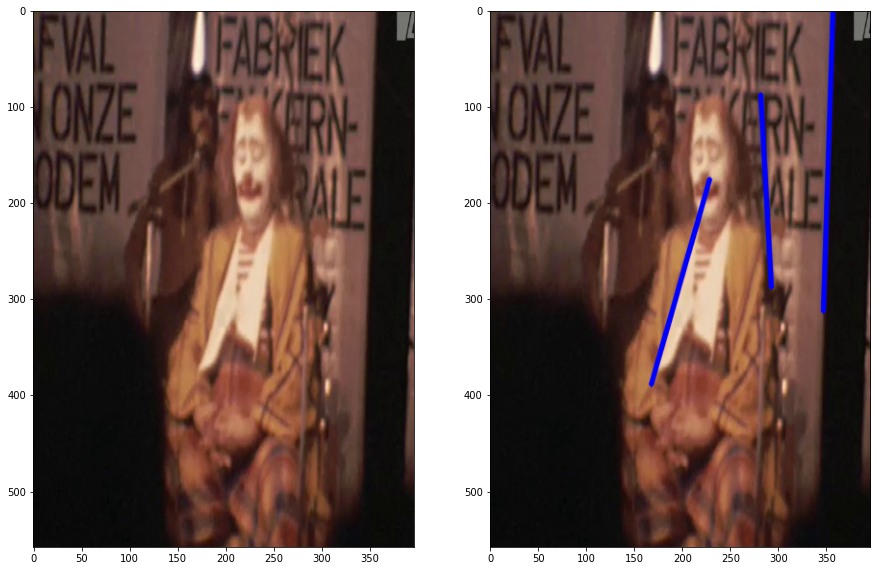

In [8]:
sample_number = 1600 # 5
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)
non_zero_objects[sample_number].rank_and_pick_lines(delta_angle=3, max_lines=3) # works in place!!
plot_lines(non_zero_objects[sample_number].img, non_zero_objects[sample_number].lines)

## Rank and pick lines for all non-zero objects ...
With all these done we can finally create our data frame with candidate matches!

In [9]:
for obj in non_zero_objects:
    obj.rank_and_pick_lines(delta_angle=3, max_lines=7) # apply line filtering
    
# INIT THE LISTS FOR THE PARAMETERS OF THE MATCHED LINES    
paths = []
angles = []
lines = []
lengths = []
scales = []

non_zero_objects_dic = {}

for obj in non_zero_objects:
    non_zero_objects_dic[obj.path] = obj
    for line_num in range(len(obj.lines)):
        paths.append(obj.path)
        scales.append(obj.scale)
        lines.append(obj.lines[line_num])
        angles.append(np.round(obj.angle[line_num][0], 2))
        lengths.append(np.round(obj.length[line_num][0], 2))
        
data = {"path": paths,"scale":scales, "angle":angles, "line": lines, "length": lengths}
data = pd.DataFrame(data)
data = data.sort_values(by = ['angle', "length"])#.set_index("path")   
data

path  scale  angle  \
26      archives/AV0539/keyframe_109.0.jpg    0.9 -90.00   
1054   archives/AV0539/keyframe_5980.0.jpg    0.9 -90.00   
1921   archives/AV0843/keyframe_5522.0.jpg    0.9 -90.00   
3896  archives/AV5361/keyframe_19718.0.jpg    0.9 -90.00   
4157  archives/AV5361/keyframe_22257.0.jpg    0.9 -90.00   
...                                    ...    ...    ...   
3211   archives/AV5361/keyframe_1336.0.jpg    0.9  89.33   
3498   archives/AV5361/keyframe_1751.0.jpg    0.9  89.33   
3788   archives/AV5361/keyframe_1898.0.jpg    0.9  89.33   
3954   archives/AV5361/keyframe_2104.0.jpg    0.9  89.33   
3982   archives/AV5361/keyframe_2108.0.jpg    0.9  89.33   

                        line  length  
26    [[420, 515, 420, 365]]  150.00  
1054    [[76, 522, 76, 372]]  150.00  
1921  [[425, 418, 425, 268]]  150.00  
3896    [[167, 150, 167, 0]]  150.00  
4157  [[292, 358, 292, 208]]  150.00  
...                      ...     ...  
3211  [[136, 195, 138, 366]]  171.01  
3498   [[154, 30, 156, 201]]  171.01  
3788    [[177, 5, 179, 176]]  171.01  
3954    [[138, 9, 140, 180]]  171.01  
3982   [[347, 16, 349, 187]]  171.01  

[6078 rows x 5 columns]

To get more insight into the lines we obtain we can plot the angle distribution and length distribution

Text(0.5, 1.0, 'Length distribution [pixels]')

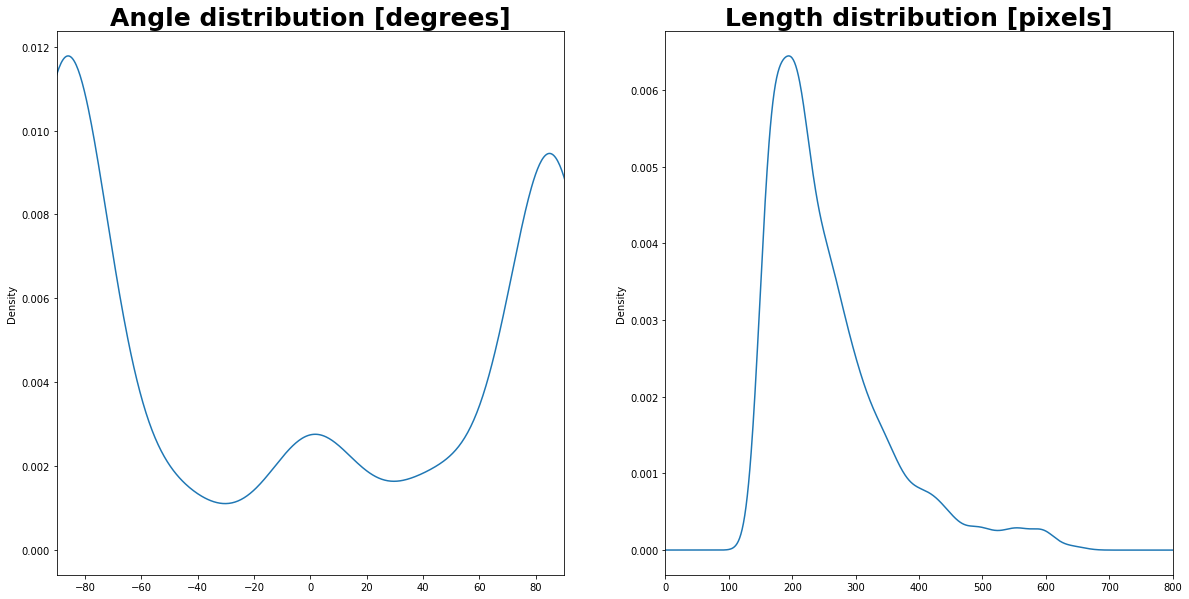

In [10]:
fig, ax = plt.subplots(ncols=2, nrows = 1, squeeze=False, figsize = (20,10))
data["angle"].plot(kind = "density", ax = ax[0,0])
ax[0,0].set_xlim((-90,90))
ax[0,0].set_title("Angle distribution [degrees]", size = 25, weight = "bold")

data["length"].plot(kind = "density", ax = ax[0,1])
ax[0,1].set_xlim((0,800))
ax[0,1].set_title("Length distribution [pixels]", size = 25, weight = "bold")

# Step 2

Now we can finally take care of our query image! Remeber, we now have to take the following steps:
- run the line extraction and filter algorithm on the query image
- choose the line(s) to be matched. How? We prefer long, non-horizontal lines.
- perform the matching procedure
- fetch the match and overlay it on the query image

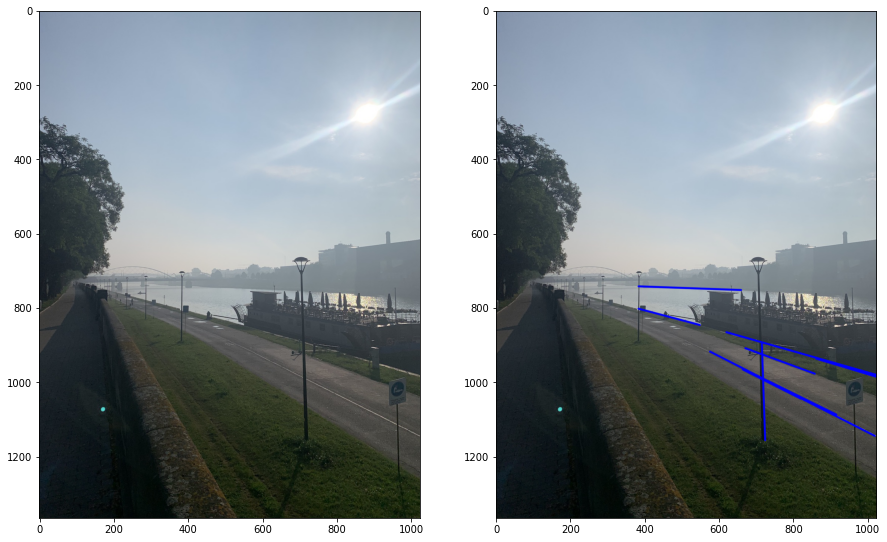

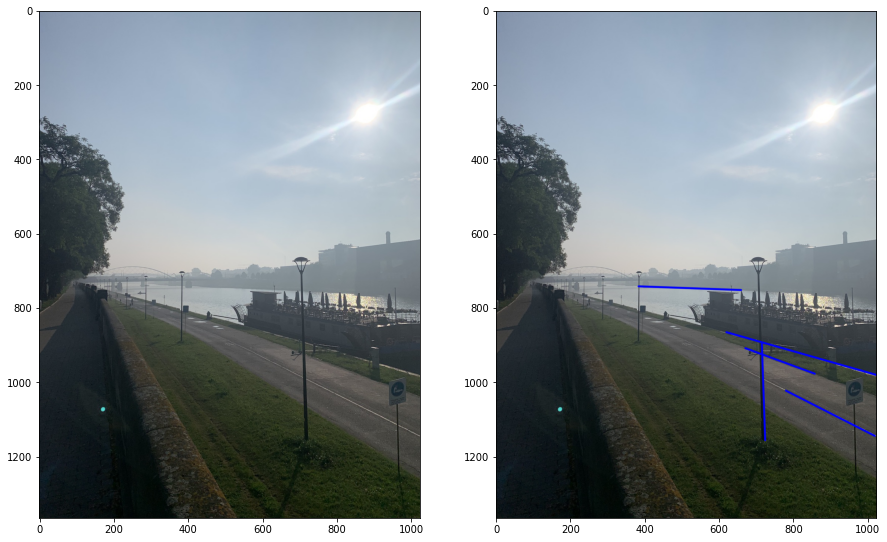

In [11]:
# Loading example image 

img = plt.imread("frames/contemporary/IMG_2864.jpeg") # downsizing each dimension to less than <1500 pixels is recommended 
#img = plt.imread("frames/contemporary/ams.jpg")


obj = matchingObjects(img = img,  scale = 1, margin = 0) # make this image matchingObject to access all the funcionalities

#params_high_res_hough_prob = {"threshold": 300, "minLineLength":150, "maxLineGap":10} # use in case large images (more than 1000 pixels in width/heigh)
params_high_res_hough_prob = {"threshold": 200, "minLineLength":150, "maxLineGap":25} # use in case large images (more than 1000 pixels in width/heigh)

#threshold = 200 # The minimum number of intersections in hough space to "detect" a line. higher -> less lines
#minLineLength = 150 # The minimum number of points that can form a line. Lines with less than this number of points are disregarded. higher -> less lines
#maxLineGap = 25 # The maximum gap between two points to be considered in the same line. higher -> more lines

obj.hough_lines(probabilistic = True, radians = False, **params_high_res_hough_prob) # detect lines

plot_lines(obj.img, obj.lines, probabilistic= True)
obj.rank_and_pick_lines(delta_angle = 3, max_lines =None) #filter out near-duplicate lines in the image
plot_lines(obj.img, obj.lines, probabilistic=True)

### Finding a match
Now we need to match the lines. We first look for a line with an angle close enough (governed by *delta_angle*) to the line in the query image, and then we take the line that has the closest length.

In [12]:
def match_lines(data, obj,delta_angle = 3):
    """
    
    Matches the lines of the given MatchingObject against the lines detected and stored in data
    
    Parameters:
    ------------------------
    data: pandas DataFrame
        database of lines with columns: path, angle, line, length
    obj: object of class MatchingObject
        an object of class matchingObjects for the query image
    delta_angle: int
        what is the furthest angle to yield a match? Note that the matches are first filtered on angle and only then on length
    TO-DO: length_prop - the proportion of length to be qualified as a match, e.g. length_prop=0.5 means that the matched length must be at least
    
    Returns:
    matches: pandas DataFrame
        dataframe of lines with columns: path, scale, angle, line, length, line coords in the input image
        
    """
    matches = pd.DataFrame()
    for i in range(len(obj.lines)):
        close_angle_data = data.loc[(data["angle"] < obj.angle[i][0] + delta_angle)  & (data["angle"] > obj.angle[i][0] - delta_angle)] # we first sort by angle as it is more important to match than length
        match = close_angle_data.iloc[(close_angle_data['length']-obj.length[i][0]).abs().argsort()][:1] # given the angle data, find the closest match in length
        match["obj_line"] = [obj.lines[i]]
        match["obj_angle"] = obj.angle[i] # just to show how great the match is, can be deleted later
        match["obj_length"] = obj.length[i]
        matches = pd.concat([matches, match])
    matches.dropna(inplace = True) 
    matches["line"] = matches["line"].apply(lambda x: x.flatten())
    matches["obj_line"] = matches["obj_line"].apply(lambda x: x.flatten())
    
    return matches

matches = match_lines(data, obj)
matches

path  scale  angle                 line  \
846   archives/AV0539/keyframe_4774.0.jpg    0.9  20.85  [41, 311, 230, 383]   
3983  archives/AV5361/keyframe_2108.0.jpg    0.9  89.14      [2, 94, 6, 359]   
1072  archives/AV0539/keyframe_6120.0.jpg    0.9  27.13  [75, 326, 319, 451]   
249   archives/AV0539/keyframe_1369.0.jpg    0.9   1.03    [43, 85, 321, 90]   
1672  archives/AV0843/keyframe_2104.0.jpg    0.9  17.90  [11, 185, 398, 310]   

      length                 obj_line  obj_angle  obj_length  
846   202.25     [669, 908, 857, 977]  20.154211  200.262328  
3983  265.03    [714, 892, 723, 1156]  88.047491  264.153365  
1072  274.16  [778, 1022, 1018, 1144]  26.945748  269.228527  
249   278.04     [382, 742, 659, 752]   2.067542  277.180447  
1672  406.69    [618, 865, 1022, 980]  15.889187  420.048807

 Once that match has been found, we want to score each line on how good it is to actually be chosen to be overalyed as in the end we will probably choose one or two lines to be overlayed on the query image.
 For that we develop a scoring methood that assigns each line a score based on angle and length (prefers long, non-horizontal lines.)

In [13]:
def score_the_line(matches, normalizing_stats, angle_weight = 1.0, length_weight = 1.0, num_lines = None):
    """
    Scores the lines striking a balance between angle (vertical lines preferred) and length (long lines preferred).
    The scoring method is based on a composite score of (normalized) angle and length, with user-specified weight for each. The normalization of each
    is done by subtracting the mean and dividing by the std.
    
    Parameters:
    -----------------------
    matches: pandas DataFrame
        dataframe of lines with columns: path, scale, angle, line, length, line coords in the input image, as returned by match_lines method
    normalizing_stats: list like
        a list-like object contating mean and standard deviation of the absolute values of angle and length respectively (list of length 4)
    angle_weight: float
        weight of the angle in the score calculation
    length_weight: float
        weight of the length in the score calculation
    data: pandas DataFrame
        database of lines from the archive with columns: path, angle, line, length. Used to calculate the statistics if not supplied in normalizing_stats
    num_lines: int
        how many lines to return. Takes num_lines with the highest score
    
        
    Returns:
    ----------------------
    best_matches: pandas DataFrame
        dataframe of lines with columns: path, scale, angle, line, length, line coords in the input image, normalized angle and length and score
    """
    matches_normalized = matches.copy()
    angle_mean, angle_std, length_mean, length_std = normalizing_stats

    matches_normalized = matches.copy()

    matches_normalized["angle_normalized"] = (abs(matches_normalized["angle"]) - angle_mean)/angle_std
    matches_normalized["length_normalized"] = (matches_normalized["length"] - length_mean)/length_std
    matches_normalized["score"] = angle_weight*matches_normalized["angle_normalized"] + length_weight*matches_normalized["length_normalized"]
    
    if num_lines == None:
        best_matches = matches_normalized.sort_values(by = "score", ascending=False)
    else:
        best_matches = matches_normalized.sort_values(by = "score", ascending=False)[:num_lines]
    return best_matches
    


In [14]:
normalizing_stats = [np.mean(abs(data["angle"])), np.std(abs(data["angle"])), np.mean(data["length"]), np.std(data["length"])]
matches = score_the_line(matches, normalizing_stats, num_lines = None, angle_weight = 1)
matches

path  scale  angle                 line  \
3983  archives/AV5361/keyframe_2108.0.jpg    0.9  89.14      [2, 94, 6, 359]   
1672  archives/AV0843/keyframe_2104.0.jpg    0.9  17.90  [11, 185, 398, 310]   
1072  archives/AV0539/keyframe_6120.0.jpg    0.9  27.13  [75, 326, 319, 451]   
249   archives/AV0539/keyframe_1369.0.jpg    0.9   1.03    [43, 85, 321, 90]   
846   archives/AV0539/keyframe_4774.0.jpg    0.9  20.85  [41, 311, 230, 383]   

      length                 obj_line  obj_angle  obj_length  \
3983  265.03    [714, 892, 723, 1156]  88.047491  264.153365   
1672  406.69    [618, 865, 1022, 980]  15.889187  420.048807   
1072  274.16  [778, 1022, 1018, 1144]  26.945748  269.228527   
249   278.04     [382, 742, 659, 752]   2.067542  277.180447   
846   202.25     [669, 908, 857, 977]  20.154211  200.262328   

      angle_normalized  length_normalized     score  
3983          0.651934           0.109520  0.761455  
1672         -2.015755           1.613425 -0.402331  
1072         -1.670124           0.206447 -1.463677  
249          -2.647478           0.247638 -2.399840  
846          -1.905288          -0.556971 -2.462259

 Additionally, we introduce some randomness into the sampling of the final line such that not always the line with the highest score gets picked.
 We make each consecutive row *factor* less likely to be sampled.

In [15]:
def sample_line(matches, num_lines=1, factor = 2):
    """
    Samples num_line lines from 'matches' using random sampling where each consecutive row is 'factor'
    times less likely to be selected.
    
    Parameters:
    -------------------------------
    matches: pandas DataFrame
        dataframe with lines ordered by score
    num_lines: int
        how many lines to return. Takes num_lines with the highest score
    factor: float
        defines how the odds of each consecutive rows change
    
    Returns:
    ----------------------------------------------
    
    matches_new.sample(...): padnas data frame
        Samples of matches
    
    """
    matches_new = matches.copy()
    start_val = 1 # does not reallt matter as numbers will be 
    probs =[start_val]
    for i in range(matches.shape[0]-1):
        probs.append(probs[i]/factor)
    
    probs = np.array(probs)
    probs = probs/np.sum(probs)
    matches_new['probs'] = probs
    
    return matches_new.sample(n = num_lines, replace = False, weights = 'probs', axis = 0)

sample_line(matches)

path  scale  angle                 line  \
1672  archives/AV0843/keyframe_2104.0.jpg    0.9   17.9  [11, 185, 398, 310]   

      length               obj_line  obj_angle  obj_length  angle_normalized  \
1672  406.69  [618, 865, 1022, 980]  15.889187  420.048807         -2.015755   

      length_normalized     score     probs  
1672           1.613425 -0.402331  0.258065

## Fetch image and overlay
Now that we detcted the lines in the query image and found the matches in our archive we can overlay the match on the image!
Below you can find the implementation of the retangular overlay.


Return the whole image

In [16]:
def get_the_line_rect(line_coords, img, margin_x = 0, margin_y =0):
    """ 
    Returns the rectangluar crop with diganol being the line with specified 'line_coords' optionally modified by a margin.
    
    Parameters:
    ---------------------------------------
    line_coords: list
        Has format  [x_start,y_start, x_end,y_end] 
    img: np.array
        an imgae
    margin_x: int
        How should the line be modified in x direction
    margin_y: int 
        How should the line be modified in x direction
        
    Returns: 
    ---------------------------------------
    matched_rect: np.array
        the cropped rectangle
    final_coords: list
        coordinates of the line the input image taking into account the margin and img_size
    
    """
    x_s,y_s,x_e,y_e = line_coords # get the coordinates of the line
    height_match, width_match, _ = img.shape
    x_s, y_s, x_e, y_e = max(min(x_s-margin_x, x_e-margin_x), 0), max(min(y_s-margin_y,y_e-margin_y),0), min(max(x_s+margin_x,x_e+margin_x), width_match), min(max(y_s+margin_y, y_e+margin_y), height_match)
   
    matched_rect = img[y_s:y_e, x_s:x_e]
    final_coords = [x_s, y_s, x_e, y_e]
    return matched_rect, final_coords
  
def overlay_on_img(img, matches, non_zero_objects_dic, margin_x = 0, margin_y= 0, adaptive_margin = True):
    """
    Takes the img and overlays the match(es) from 'matches' on it.
    
    Parameters:
    ---------------------------------------
    img: np.array
        an imgae
    matches: pandas DataFrame
        dataframe of lines with columns: path, scale, angle, line, length, line coords in the input image, normalized angle and length and score
    non_zero_objects_dic: dictionary
        Dictionary with keys being paths to the images in the archive that have lines and keys being the matchingObjects that store them. Allows for fast overlaying.
    margin_x: int
        How should the line be modified in x direction
    margin_y: int 
        How should the line be modified in x direction
    adaptive_margin: bool
        Specifies if the automatic margin should be performed. 
        Automatic margin adds the margin based on trainge weight function. The added margin is 0 at 45 degrees and symmetric around 45 degrees.
        
        
    Returns: 
    ---------------------------------------
    matched_rect: np.array
        the cropped rectangle
    
    """
    new_img = img.copy()
    
    if adaptive_margin == True:
        weights = np.concatenate( (np.linspace(start = 30, stop = 0, num = 45), np.linspace(start = 0, stop = 30, num = 46) )) # maximally 15 pixels will be added
        weights_dic = {}
        for angle, weight in enumerate(weights):
            weights_dic[angle] = round(weight)
        
    for row_num in range(matches.shape[0]):
        row = matches.iloc[row_num] # 
        the_match_obj = non_zero_objects_dic[row["path"]] # fetch the object from dic
        
        
        if adaptive_margin:
            angle = round(abs(row["angle"]))
            if angle < 45: # increase the margin in y direction
                margin_y = weights_dic[angle]
            else: 
                margin_x = weights_dic[angle]

            
            
        matched_rect, _ = get_the_line_rect(line_coords = row['line'], img = the_match_obj.img, margin_x=margin_x, margin_y = margin_y) # get the part to paste
        
        input_img_rect, input_coords = get_the_line_rect(line_coords = row['obj_line'], img = img, margin_x=margin_x, margin_y = margin_y)
        height_input, width_input,  _ = input_img_rect.shape
        
        matched_rect = cv2.resize(matched_rect, (width_input, height_input))
        
        new_img[input_coords[1]:input_coords[3], input_coords[0]:input_coords[2]] = matched_rect
        
    return new_img
        

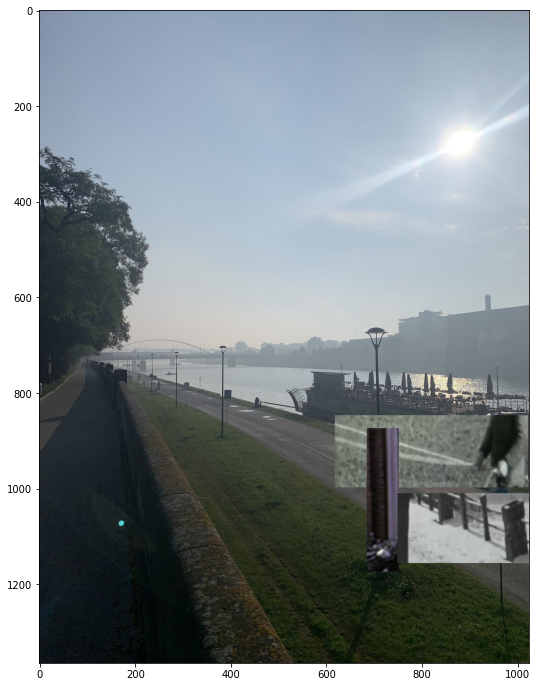

In [17]:
plt.figure(figsize = (12,12))
plt.imshow(overlay_on_img(img, sample_line(matches, num_lines = 3), non_zero_objects_dic,adaptive_margin = True))

### Other overalying approaches
Of course, we might want to overlay a match on the query image in a different way, for instance using a circle. How would one go about this?
All overlaying approaches within this framework would use 3 arguments:
- img: a query image
- matches: a dataframe of matches
- non_zero_objects_dic: a dictionary with keys being paths and values being matchingObjects objects. 

Then, looking at ***matches*** we see that we have all the info we need: the line coordinates in the query image and matched image, the query image itself and the matchinObjects object for the match (from which we can get the img as np array by doing something like `` non_zero_objects_dic[match_path].img ``

In [18]:
sample_line(matches)

path  scale  angle                 line  \
1072  archives/AV0539/keyframe_6120.0.jpg    0.9  27.13  [75, 326, 319, 451]   

      length                 obj_line  obj_angle  obj_length  \
1072  274.16  [778, 1022, 1018, 1144]  26.945748  269.228527   

      angle_normalized  length_normalized     score     probs  
1072         -1.670124           0.206447 -1.463677  0.129032

In [19]:
def differnt_overlay(img, matches, non_zero_objects_dic):
    """
    Takes the img and overlays the match(es) from 'matches' on it.
    
    Parameters:
    ---------------------------------------
    img: np.array
        an imgae
    matches: pandas DataFrame
        dataframe of lines with columns: path, scale, angle, line, length, line coords in the input image, normalized angle and length and score
    non_zero_objects_dic: dictionary
        Dictionary with keys being paths to the images in the archive that have lines and keys being the matchingObjects that store them. Allows for fast overlaying.
        
    ################################
    
        YOUR EXTRA ARGUMENTS
        
    #################################
        
    Returns: 
    ---------------------------------------
    overlayed: np.array
        An image with overlayed match
    
    """
    
    new_img = img.copy()
    
    for row_num in range(matches.shape[0]): # for each matched line ...
        
        row = matches.iloc[row_num] # one row of matches
        the_match_obj = non_zero_objects_dic[row["path"]] # get the matched object from the dictinary. To access the whole image now do the_match_obj.img
    
        
    ##############################
    
    # PUT YOUR CODE HERE
    
    ##############################
        
    raise NotImplementedError

### We can wrap the entire Step 2 into 1 sleek function

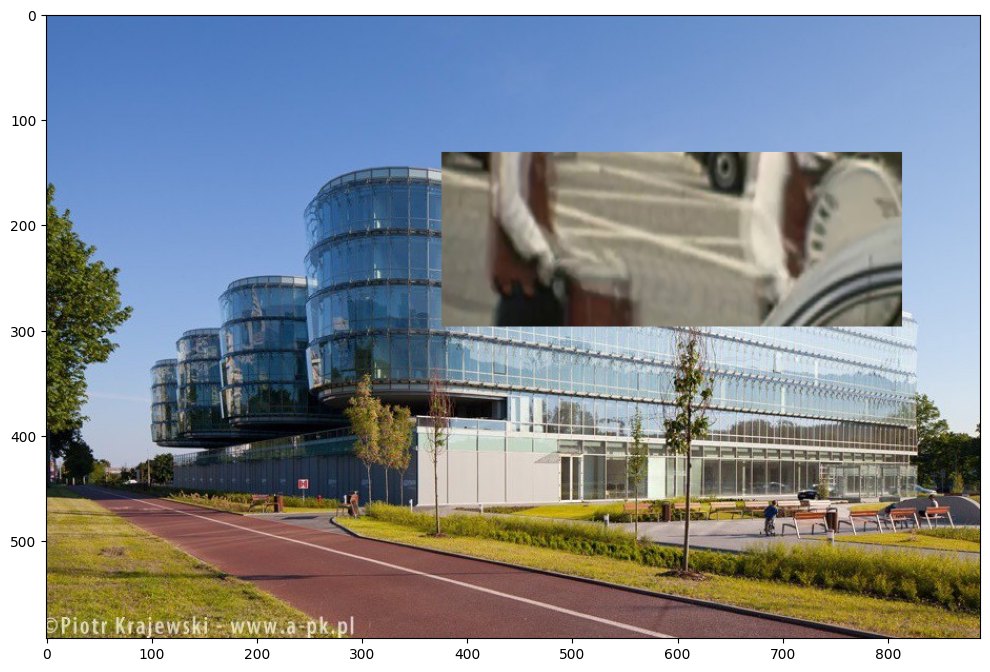

In [20]:
def all_in_one(path, data = data, normalizing_stats = None, params_hough = {"threshold": 200, "minLineLength":150, "maxLineGap":25}):
    """Given a query image and database of matches, finds a match and overlays it on the query image."""
    
    
    img = plt.imread(path) # read in query image
    obj = matchingObjects(img = img,  scale = 1, margin = 0) # make it a matchingObject class
    obj.hough_lines(probabilistic = True, radians = False, **params_hough) # detect lines
    obj.rank_and_pick_lines(delta_angle = 3, max_lines =None) # filter similiar lines
    matches = match_lines(data, obj) # find matches
    
    # Calculate the score for each candidate match
    if normalizing_stats is None: 
        normalizing_stats = [np.mean(abs(data["angle"])), np.std(abs(data["angle"])), np.mean(data["length"]), np.std(data["length"])]
    matches = score_the_line(matches, normalizing_stats, num_lines = None)
    
    overlayed = overlay_on_img(img, sample_line(matches), non_zero_objects_dic, adaptive_margin = True) # randomly sample one line and overlay on image 
    
    return overlayed

lst_paths = ["frames/contemporary/IMG_2864.jpeg", "frames/contemporary/ams.jpg", "frames/contemporary/gdy.jpg", "frames/contemporary/bike.jpeg", "frames/contemporary/balcony.jpeg"]

img = all_in_one(lst_paths[2])
plt.figure(figsize = (10,8), dpi = 100)
plt.imshow(img)
plt.tight_layout()

#save_path = "frames/sample_outputs"
#plt.savefig(os.path.join(save_path, "balcony2FalseLine.jpeg"))

## How fast is it?

In [21]:
start = time.time()
count = 0
for i in range(10):
    for k in range(len(lst_paths)):
        count += 1
        all_in_one(lst_paths[k])
end = time.time()

print("On average one interpretation takes {} seconds".format((end-start)/count))

On average one interpretation takes 0.11665470123291016 seconds


Quite a ride, he?